In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/paulo.cotta/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/paulo.cotta/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/paulo.cotta/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/paulo.cotta/opt/ana

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 9s 1us/step
(60000, 784)


In [3]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
g=create_generator()
g.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
________________________________________________

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1
Instructions for updating:
Use tf.cast instead.


  2%|▏         | 2/128 [00:00<00:08, 15.70it/s]

Epoch 2


  2%|▏         | 2/128 [00:00<00:07, 16.70it/s]

Epoch 3


  2%|▏         | 2/128 [00:00<00:07, 16.33it/s]

Epoch 4


  2%|▏         | 2/128 [00:00<00:07, 15.81it/s]

Epoch 5


  2%|▏         | 2/128 [00:00<00:07, 16.17it/s]

Epoch 6


  2%|▏         | 2/128 [00:00<00:07, 16.88it/s]

Epoch 7


  2%|▏         | 2/128 [00:00<00:07, 17.21it/s]

Epoch 8


  2%|▏         | 2/128 [00:00<00:07, 16.46it/s]

Epoch 9


  2%|▏         | 2/128 [00:00<00:07, 16.55it/s]

Epoch 10


  2%|▏         | 2/128 [00:00<00:07, 16.55it/s]

Epoch 11


  2%|▏         | 2/128 [00:00<00:07, 16.55it/s]

Epoch 12


  2%|▏         | 2/128 [00:00<00:07, 16.39it/s]

Epoch 13


  2%|▏         | 2/128 [00:00<00:07, 16.25it/s]

Epoch 14


  2%|▏         | 2/128 [00:00<00:07, 16.66it/s]

Epoch 15


  2%|▏         | 2/128 [00:00<00:07, 16.56it/s]

Epoch 16


  2%|▏         | 2/128 [00:00<00:07, 16.63it/s]

Epoch 17


  2%|▏         | 2/128 [00:00<00:07, 16.60it/s]

Epoch 18


  2%|▏         | 2/128 [00:00<00:07, 16.54it/s]

Epoch 19


  2%|▏         | 2/128 [00:00<00:07, 16.47it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:07, 17.04it/s]

Epoch 21


  2%|▏         | 2/128 [00:00<00:07, 16.36it/s]

Epoch 22


  2%|▏         | 2/128 [00:00<00:08, 15.52it/s]

Epoch 23


  2%|▏         | 2/128 [00:00<00:06, 18.06it/s]

Epoch 24


  2%|▏         | 2/128 [00:00<00:07, 17.72it/s]

Epoch 25


  2%|▏         | 2/128 [00:00<00:06, 18.34it/s]

Epoch 26


  2%|▏         | 2/128 [00:00<00:06, 18.83it/s]

Epoch 27


  2%|▏         | 2/128 [00:00<00:06, 18.42it/s]

Epoch 28


  2%|▏         | 2/128 [00:00<00:06, 18.64it/s]

Epoch 29


  2%|▏         | 2/128 [00:00<00:06, 18.57it/s]

Epoch 30


  2%|▏         | 2/128 [00:00<00:06, 18.68it/s]

Epoch 31


  2%|▏         | 2/128 [00:00<00:06, 18.67it/s]

Epoch 32


  2%|▏         | 2/128 [00:00<00:06, 18.48it/s]

Epoch 33


  2%|▏         | 2/128 [00:00<00:06, 19.48it/s]

Epoch 34


  2%|▏         | 2/128 [00:00<00:08, 14.50it/s]

Epoch 35


  2%|▏         | 2/128 [00:00<00:06, 18.97it/s]

Epoch 36


  2%|▏         | 2/128 [00:00<00:08, 15.34it/s]

Epoch 37


  2%|▏         | 2/128 [00:00<00:06, 18.77it/s]

Epoch 38


  2%|▏         | 2/128 [00:00<00:06, 19.01it/s]

Epoch 39


  2%|▏         | 2/128 [00:00<00:06, 19.49it/s]

Epoch 40


  2%|▏         | 2/128 [00:00<00:06, 19.31it/s]

Epoch 41


  2%|▏         | 2/128 [00:00<00:06, 19.01it/s]

Epoch 42


  2%|▏         | 2/128 [00:00<00:06, 19.19it/s]

Epoch 43


  2%|▏         | 2/128 [00:00<00:06, 19.00it/s]

Epoch 44


  2%|▏         | 2/128 [00:00<00:06, 18.89it/s]

Epoch 45


  2%|▏         | 2/128 [00:00<00:07, 16.12it/s]

Epoch 46


  2%|▏         | 2/128 [00:00<00:07, 17.91it/s]

Epoch 47


  2%|▏         | 2/128 [00:00<00:07, 17.28it/s]

Epoch 48


  2%|▏         | 2/128 [00:00<00:07, 15.88it/s]

Epoch 49


  2%|▏         | 2/128 [00:00<00:07, 16.16it/s]

Epoch 50


  2%|▏         | 2/128 [00:00<00:06, 18.84it/s]

Epoch 51


  2%|▏         | 2/128 [00:00<00:06, 19.00it/s]

Epoch 52


  2%|▏         | 2/128 [00:00<00:06, 18.41it/s]

Epoch 53


  2%|▏         | 2/128 [00:00<00:06, 18.24it/s]

Epoch 54


  2%|▏         | 2/128 [00:00<00:06, 18.38it/s]

Epoch 55


  2%|▏         | 2/128 [00:00<00:08, 15.00it/s]

Epoch 56


  2%|▏         | 2/128 [00:00<00:06, 18.10it/s]

Epoch 57


  2%|▏         | 2/128 [00:00<00:06, 18.24it/s]

Epoch 58


  2%|▏         | 2/128 [00:00<00:06, 18.69it/s]

Epoch 59


  2%|▏         | 2/128 [00:00<00:06, 18.33it/s]

Epoch 60


  2%|▏         | 2/128 [00:00<00:06, 18.89it/s]

Epoch 61


  2%|▏         | 2/128 [00:00<00:09, 13.79it/s]

Epoch 62


  2%|▏         | 2/128 [00:00<00:06, 19.08it/s]

Epoch 63


  2%|▏         | 2/128 [00:00<00:06, 19.21it/s]

Epoch 64


  2%|▏         | 2/128 [00:00<00:06, 19.06it/s]

Epoch 65


  2%|▏         | 2/128 [00:00<00:06, 19.25it/s]

Epoch 66


  2%|▏         | 2/128 [00:00<00:06, 19.20it/s]

Epoch 67


  2%|▏         | 2/128 [00:00<00:06, 18.18it/s]

Epoch 68


  2%|▏         | 2/128 [00:00<00:07, 17.45it/s]

Epoch 69


  2%|▏         | 2/128 [00:00<00:07, 16.46it/s]

Epoch 70


  2%|▏         | 2/128 [00:00<00:08, 15.73it/s]

Epoch 71


  2%|▏         | 2/128 [00:00<00:10, 12.36it/s]

Epoch 72


  2%|▏         | 2/128 [00:00<00:07, 17.86it/s]

Epoch 73


  2%|▏         | 2/128 [00:00<00:07, 17.83it/s]

Epoch 74


  2%|▏         | 2/128 [00:00<00:06, 18.22it/s]

Epoch 75


  2%|▏         | 2/128 [00:00<00:07, 17.30it/s]

Epoch 76


  2%|▏         | 2/128 [00:00<00:07, 17.85it/s]

Epoch 77


  2%|▏         | 2/128 [00:00<00:06, 18.60it/s]

Epoch 78


  2%|▏         | 2/128 [00:00<00:06, 19.00it/s]

Epoch 79


  2%|▏         | 2/128 [00:00<00:06, 19.53it/s]

Epoch 80


  2%|▏         | 2/128 [00:00<00:07, 16.82it/s]

Epoch 81


  2%|▏         | 2/128 [00:00<00:08, 15.55it/s]

Epoch 82


  2%|▏         | 2/128 [00:00<00:07, 16.18it/s]

Epoch 83


  2%|▏         | 2/128 [00:00<00:07, 16.56it/s]

Epoch 84


  2%|▏         | 2/128 [00:00<00:09, 12.66it/s]

Epoch 85


  2%|▏         | 2/128 [00:00<00:07, 17.22it/s]

Epoch 86


  2%|▏         | 2/128 [00:00<00:07, 17.61it/s]

Epoch 87


  2%|▏         | 2/128 [00:00<00:06, 18.71it/s]

Epoch 88


  2%|▏         | 2/128 [00:00<00:06, 18.73it/s]

Epoch 89


  2%|▏         | 2/128 [00:00<00:06, 19.24it/s]

Epoch 90


  2%|▏         | 2/128 [00:00<00:06, 19.00it/s]

Epoch 91


  2%|▏         | 2/128 [00:00<00:08, 14.84it/s]

Epoch 92


  2%|▏         | 2/128 [00:00<00:07, 16.26it/s]

Epoch 93


  2%|▏         | 2/128 [00:00<00:07, 16.39it/s]

Epoch 94


  2%|▏         | 2/128 [00:00<00:07, 16.83it/s]

Epoch 95


  2%|▏         | 2/128 [00:00<00:09, 13.32it/s]

Epoch 96


  2%|▏         | 2/128 [00:00<00:07, 16.41it/s]

Epoch 97


  2%|▏         | 2/128 [00:00<00:07, 16.57it/s]

Epoch 98


  2%|▏         | 2/128 [00:00<00:07, 17.00it/s]

Epoch 99


  2%|▏         | 2/128 [00:00<00:08, 15.51it/s]

Epoch 100


  2%|▏         | 2/128 [00:00<00:06, 18.20it/s]

Epoch 101


  2%|▏         | 2/128 [00:00<00:07, 16.87it/s]

Epoch 102


  2%|▏         | 2/128 [00:00<00:07, 16.33it/s]

Epoch 103


  2%|▏         | 2/128 [00:00<00:07, 16.10it/s]

Epoch 104


  2%|▏         | 2/128 [00:00<00:07, 16.32it/s]

Epoch 105


  2%|▏         | 2/128 [00:00<00:07, 17.49it/s]

Epoch 106


  2%|▏         | 2/128 [00:00<00:06, 18.79it/s]

Epoch 107


  2%|▏         | 2/128 [00:00<00:06, 18.67it/s]

Epoch 108


  2%|▏         | 2/128 [00:00<00:07, 16.22it/s]

Epoch 109


  2%|▏         | 2/128 [00:00<00:09, 13.67it/s]

Epoch 110


  2%|▏         | 2/128 [00:00<00:08, 14.41it/s]

Epoch 111


  2%|▏         | 2/128 [00:00<00:08, 15.22it/s]

Epoch 112


  2%|▏         | 2/128 [00:00<00:07, 16.43it/s]

Epoch 113


  2%|▏         | 2/128 [00:00<00:07, 17.97it/s]

Epoch 114


  2%|▏         | 2/128 [00:00<00:06, 19.23it/s]

Epoch 115


  2%|▏         | 2/128 [00:00<00:06, 18.96it/s]

Epoch 116


  2%|▏         | 2/128 [00:00<00:06, 19.31it/s]

Epoch 117


  2%|▏         | 2/128 [00:00<00:07, 17.57it/s]

Epoch 118


  2%|▏         | 2/128 [00:00<00:07, 17.87it/s]

Epoch 119


  2%|▏         | 2/128 [00:00<00:07, 17.21it/s]

Epoch 120


  2%|▏         | 2/128 [00:00<00:06, 18.70it/s]

Epoch 121


  2%|▏         | 2/128 [00:00<00:06, 18.85it/s]

Epoch 122


  2%|▏         | 2/128 [00:00<00:07, 17.50it/s]

Epoch 123


  2%|▏         | 2/128 [00:00<00:07, 17.49it/s]

Epoch 124


  2%|▏         | 2/128 [00:00<00:07, 17.03it/s]

Epoch 125


  2%|▏         | 2/128 [00:00<00:08, 15.09it/s]

Epoch 126


  2%|▏         | 2/128 [00:00<00:08, 14.32it/s]

Epoch 127


  2%|▏         | 2/128 [00:00<00:07, 17.43it/s]

Epoch 128


  2%|▏         | 2/128 [00:00<00:09, 13.63it/s]

Epoch 129


  2%|▏         | 2/128 [00:00<00:07, 17.24it/s]

Epoch 130


  2%|▏         | 2/128 [00:00<00:07, 17.69it/s]

Epoch 131


  2%|▏         | 2/128 [00:00<00:07, 16.33it/s]

Epoch 132


  2%|▏         | 2/128 [00:00<00:09, 13.76it/s]

Epoch 133


  2%|▏         | 2/128 [00:00<00:07, 16.92it/s]

Epoch 134


  2%|▏         | 2/128 [00:00<00:07, 16.30it/s]

Epoch 135


  2%|▏         | 2/128 [00:00<00:07, 17.57it/s]

Epoch 136


  2%|▏         | 2/128 [00:00<00:07, 16.82it/s]

Epoch 137


  2%|▏         | 2/128 [00:00<00:07, 17.18it/s]

Epoch 138


  2%|▏         | 2/128 [00:00<00:08, 15.51it/s]

Epoch 139


  2%|▏         | 2/128 [00:00<00:07, 17.74it/s]

Epoch 140


  2%|▏         | 2/128 [00:00<00:06, 19.08it/s]

Epoch 141


  2%|▏         | 2/128 [00:00<00:06, 19.34it/s]

Epoch 142


  2%|▏         | 2/128 [00:00<00:07, 17.83it/s]

Epoch 143


  2%|▏         | 2/128 [00:00<00:07, 17.72it/s]

Epoch 144


  2%|▏         | 2/128 [00:00<00:07, 17.73it/s]

Epoch 145


  2%|▏         | 2/128 [00:00<00:07, 17.55it/s]

Epoch 146


  2%|▏         | 2/128 [00:00<00:07, 17.86it/s]

Epoch 147


  2%|▏         | 2/128 [00:00<00:08, 14.75it/s]

Epoch 148


  2%|▏         | 2/128 [00:00<00:10, 12.17it/s]

Epoch 149


  2%|▏         | 2/128 [00:00<00:07, 16.83it/s]

Epoch 150


  2%|▏         | 2/128 [00:00<00:07, 16.50it/s]

Epoch 151


  2%|▏         | 2/128 [00:00<00:09, 13.69it/s]

Epoch 152


  2%|▏         | 2/128 [00:00<00:08, 15.70it/s]

Epoch 153


  2%|▏         | 2/128 [00:00<00:07, 16.39it/s]

Epoch 154


  2%|▏         | 2/128 [00:00<00:08, 15.50it/s]

Epoch 155


  2%|▏         | 2/128 [00:00<00:07, 16.97it/s]

Epoch 156


  2%|▏         | 2/128 [00:00<00:07, 16.77it/s]

Epoch 157


  2%|▏         | 2/128 [00:00<00:07, 17.38it/s]

Epoch 158


  2%|▏         | 2/128 [00:00<00:07, 16.96it/s]

Epoch 159


  2%|▏         | 2/128 [00:00<00:07, 16.66it/s]

Epoch 160


  2%|▏         | 2/128 [00:00<00:07, 17.71it/s]

Epoch 161


  2%|▏         | 2/128 [00:00<00:08, 15.75it/s]

Epoch 162


  2%|▏         | 2/128 [00:00<00:07, 16.33it/s]

Epoch 163


  2%|▏         | 2/128 [00:00<00:07, 17.06it/s]

Epoch 164


  2%|▏         | 2/128 [00:00<00:07, 16.83it/s]

Epoch 165


  2%|▏         | 2/128 [00:00<00:07, 17.28it/s]

Epoch 166


  2%|▏         | 2/128 [00:00<00:09, 13.51it/s]

Epoch 167


  2%|▏         | 2/128 [00:00<00:08, 14.61it/s]

Epoch 168


  2%|▏         | 2/128 [00:00<00:07, 16.29it/s]

Epoch 169


  2%|▏         | 2/128 [00:00<00:10, 12.30it/s]

Epoch 170


  2%|▏         | 2/128 [00:00<00:09, 13.67it/s]

Epoch 171


  2%|▏         | 2/128 [00:00<00:07, 16.43it/s]

Epoch 172


  2%|▏         | 2/128 [00:00<00:07, 16.67it/s]

Epoch 173


  2%|▏         | 2/128 [00:00<00:07, 16.37it/s]

Epoch 174


  2%|▏         | 2/128 [00:00<00:07, 17.48it/s]

Epoch 175


  2%|▏         | 2/128 [00:00<00:07, 17.41it/s]

Epoch 176


  2%|▏         | 2/128 [00:00<00:09, 13.64it/s]

Epoch 177


  2%|▏         | 2/128 [00:00<00:09, 13.03it/s]

Epoch 178


  2%|▏         | 2/128 [00:00<00:09, 12.64it/s]

Epoch 179


  2%|▏         | 2/128 [00:00<00:08, 15.35it/s]

Epoch 180


  2%|▏         | 2/128 [00:00<00:06, 18.16it/s]

Epoch 181


  2%|▏         | 2/128 [00:00<00:07, 16.35it/s]

Epoch 182


  2%|▏         | 2/128 [00:00<00:10, 12.33it/s]

Epoch 183


  2%|▏         | 2/128 [00:00<00:07, 17.07it/s]

Epoch 184


  2%|▏         | 2/128 [00:00<00:07, 17.63it/s]

Epoch 185


  2%|▏         | 2/128 [00:00<00:06, 18.22it/s]

Epoch 186


  2%|▏         | 2/128 [00:00<00:06, 18.83it/s]

Epoch 187


  2%|▏         | 2/128 [00:00<00:07, 16.22it/s]

Epoch 188


  2%|▏         | 2/128 [00:00<00:07, 16.18it/s]

Epoch 189


  2%|▏         | 2/128 [00:00<00:08, 14.51it/s]

Epoch 190


  2%|▏         | 2/128 [00:00<00:10, 12.02it/s]

Epoch 191


  2%|▏         | 2/128 [00:00<00:10, 12.38it/s]

Epoch 192


  2%|▏         | 2/128 [00:00<00:08, 15.65it/s]

Epoch 193


  2%|▏         | 2/128 [00:00<00:07, 17.23it/s]

Epoch 194


  2%|▏         | 2/128 [00:00<00:07, 17.72it/s]

Epoch 195


  2%|▏         | 2/128 [00:00<00:07, 16.83it/s]

Epoch 196


  2%|▏         | 2/128 [00:00<00:07, 16.52it/s]

Epoch 197


  2%|▏         | 2/128 [00:00<00:07, 16.22it/s]

Epoch 198


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 199


  2%|▏         | 2/128 [00:00<00:07, 17.37it/s]

Epoch 200


  2%|▏         | 2/128 [00:00<00:08, 15.50it/s]

Epoch 201


  2%|▏         | 2/128 [00:00<00:07, 16.89it/s]

Epoch 202


  2%|▏         | 2/128 [00:00<00:07, 15.98it/s]

Epoch 203


  2%|▏         | 2/128 [00:00<00:07, 16.14it/s]

Epoch 204


  2%|▏         | 2/128 [00:00<00:07, 16.96it/s]

Epoch 205


  2%|▏         | 2/128 [00:00<00:08, 15.30it/s]

Epoch 206


  2%|▏         | 2/128 [00:00<00:07, 17.05it/s]

Epoch 207


  2%|▏         | 2/128 [00:00<00:07, 16.95it/s]

Epoch 208


  2%|▏         | 2/128 [00:00<00:07, 17.32it/s]

Epoch 209


  2%|▏         | 2/128 [00:00<00:07, 17.02it/s]

Epoch 210


  2%|▏         | 2/128 [00:00<00:07, 16.14it/s]

Epoch 211


  2%|▏         | 2/128 [00:00<00:08, 15.66it/s]

Epoch 212


  2%|▏         | 2/128 [00:00<00:07, 16.32it/s]

Epoch 213


  2%|▏         | 2/128 [00:00<00:07, 16.34it/s]

Epoch 214


  2%|▏         | 2/128 [00:00<00:07, 17.08it/s]

Epoch 215


  2%|▏         | 2/128 [00:00<00:07, 17.04it/s]

Epoch 216


  2%|▏         | 2/128 [00:00<00:07, 16.79it/s]

Epoch 217


  2%|▏         | 2/128 [00:00<00:07, 17.17it/s]

Epoch 218


  2%|▏         | 2/128 [00:00<00:07, 17.41it/s]

Epoch 219


  2%|▏         | 2/128 [00:00<00:08, 15.63it/s]

Epoch 220


  2%|▏         | 2/128 [00:00<00:07, 15.97it/s]

Epoch 221


  2%|▏         | 2/128 [00:00<00:07, 16.77it/s]

Epoch 222


  2%|▏         | 2/128 [00:00<00:08, 15.66it/s]

Epoch 223


  2%|▏         | 2/128 [00:00<00:07, 15.89it/s]

Epoch 224


  2%|▏         | 2/128 [00:00<00:07, 16.65it/s]

Epoch 225


  2%|▏         | 2/128 [00:00<00:07, 17.04it/s]

Epoch 226


  2%|▏         | 2/128 [00:00<00:08, 14.48it/s]

Epoch 227


  2%|▏         | 2/128 [00:00<00:07, 17.70it/s]

Epoch 228


  2%|▏         | 2/128 [00:00<00:07, 17.16it/s]

Epoch 229


  2%|▏         | 2/128 [00:00<00:07, 16.47it/s]

Epoch 230


  2%|▏         | 2/128 [00:00<00:07, 17.06it/s]

Epoch 231


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 232


  2%|▏         | 2/128 [00:00<00:08, 15.62it/s]

Epoch 233


  2%|▏         | 2/128 [00:00<00:07, 16.50it/s]

Epoch 234


  2%|▏         | 2/128 [00:00<00:07, 16.43it/s]

Epoch 235


  2%|▏         | 2/128 [00:00<00:07, 17.31it/s]

Epoch 236


  2%|▏         | 2/128 [00:00<00:07, 16.61it/s]

Epoch 237


  2%|▏         | 2/128 [00:00<00:07, 17.30it/s]

Epoch 238


  2%|▏         | 2/128 [00:00<00:07, 16.15it/s]

Epoch 239


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 240


  2%|▏         | 2/128 [00:00<00:07, 17.88it/s]

Epoch 241


  2%|▏         | 2/128 [00:00<00:07, 17.14it/s]

Epoch 242


  2%|▏         | 2/128 [00:00<00:07, 16.73it/s]

Epoch 243


  2%|▏         | 2/128 [00:00<00:07, 16.91it/s]

Epoch 244


  2%|▏         | 2/128 [00:00<00:07, 16.28it/s]

Epoch 245


  2%|▏         | 2/128 [00:00<00:07, 16.94it/s]

Epoch 246


  2%|▏         | 2/128 [00:00<00:07, 16.09it/s]

Epoch 247


  2%|▏         | 2/128 [00:00<00:07, 16.76it/s]

Epoch 248


  2%|▏         | 2/128 [00:00<00:07, 16.78it/s]

Epoch 249


  2%|▏         | 2/128 [00:00<00:07, 17.28it/s]

Epoch 250


  2%|▏         | 2/128 [00:00<00:07, 16.52it/s]

Epoch 251


  2%|▏         | 2/128 [00:00<00:07, 16.84it/s]

Epoch 252


  2%|▏         | 2/128 [00:00<00:08, 14.24it/s]

Epoch 253


  2%|▏         | 2/128 [00:00<00:09, 12.93it/s]

Epoch 254


  2%|▏         | 2/128 [00:00<00:09, 13.67it/s]

Epoch 255


  2%|▏         | 2/128 [00:00<00:07, 16.47it/s]

Epoch 256


  2%|▏         | 2/128 [00:00<00:08, 15.73it/s]

Epoch 257


  2%|▏         | 2/128 [00:00<00:08, 15.43it/s]

Epoch 258


  2%|▏         | 2/128 [00:00<00:07, 16.24it/s]

Epoch 259


  2%|▏         | 2/128 [00:00<00:07, 16.92it/s]

Epoch 260


  2%|▏         | 2/128 [00:00<00:07, 17.93it/s]

Epoch 261


  2%|▏         | 2/128 [00:00<00:06, 18.14it/s]

Epoch 262


  2%|▏         | 2/128 [00:00<00:07, 17.05it/s]

Epoch 263


  2%|▏         | 2/128 [00:00<00:07, 16.64it/s]

Epoch 264


  2%|▏         | 2/128 [00:00<00:07, 16.92it/s]

Epoch 265


  2%|▏         | 2/128 [00:00<00:07, 17.04it/s]

Epoch 266


  2%|▏         | 2/128 [00:00<00:07, 15.96it/s]

Epoch 267


  2%|▏         | 2/128 [00:00<00:10, 12.45it/s]

Epoch 268


  2%|▏         | 2/128 [00:00<00:08, 15.55it/s]

Epoch 269


  2%|▏         | 2/128 [00:00<00:08, 15.58it/s]

Epoch 270


  2%|▏         | 2/128 [00:00<00:07, 16.00it/s]

Epoch 271


  2%|▏         | 2/128 [00:00<00:07, 17.28it/s]

Epoch 272


  2%|▏         | 2/128 [00:00<00:06, 18.66it/s]

Epoch 273


  2%|▏         | 2/128 [00:00<00:06, 18.64it/s]

Epoch 274


  2%|▏         | 2/128 [00:00<00:06, 19.40it/s]

Epoch 275


  2%|▏         | 2/128 [00:00<00:06, 19.40it/s]

Epoch 276


  2%|▏         | 2/128 [00:00<00:08, 14.53it/s]

Epoch 277


  2%|▏         | 2/128 [00:00<00:07, 17.38it/s]

Epoch 278


  2%|▏         | 2/128 [00:00<00:07, 17.19it/s]

Epoch 279


  2%|▏         | 2/128 [00:00<00:07, 16.83it/s]

Epoch 280


  2%|▏         | 2/128 [00:00<00:07, 16.71it/s]

Epoch 281


  2%|▏         | 2/128 [00:00<00:08, 15.04it/s]

Epoch 282


  2%|▏         | 2/128 [00:00<00:08, 15.56it/s]

Epoch 283


  2%|▏         | 2/128 [00:00<00:07, 15.92it/s]

Epoch 284


  2%|▏         | 2/128 [00:00<00:07, 17.05it/s]

Epoch 285


  2%|▏         | 2/128 [00:00<00:06, 18.43it/s]

Epoch 286


  2%|▏         | 2/128 [00:00<00:06, 18.16it/s]

Epoch 287


  2%|▏         | 2/128 [00:00<00:06, 18.44it/s]

Epoch 288


  2%|▏         | 2/128 [00:00<00:07, 17.91it/s]

Epoch 289


  2%|▏         | 2/128 [00:00<00:07, 17.54it/s]

Epoch 290


  2%|▏         | 2/128 [00:00<00:07, 17.36it/s]

Epoch 291


  2%|▏         | 2/128 [00:00<00:07, 17.30it/s]

Epoch 292


  2%|▏         | 2/128 [00:00<00:07, 17.06it/s]

Epoch 293


  2%|▏         | 2/128 [00:00<00:07, 17.40it/s]

Epoch 294


  2%|▏         | 2/128 [00:00<00:07, 17.51it/s]

Epoch 295


  2%|▏         | 2/128 [00:00<00:07, 17.86it/s]

Epoch 296


  2%|▏         | 2/128 [00:00<00:07, 17.93it/s]

Epoch 297


  2%|▏         | 2/128 [00:00<00:07, 17.49it/s]

Epoch 298


  2%|▏         | 2/128 [00:00<00:07, 17.50it/s]

Epoch 299


  2%|▏         | 2/128 [00:00<00:07, 17.50it/s]

Epoch 300


  2%|▏         | 2/128 [00:00<00:06, 18.70it/s]

Epoch 301


  2%|▏         | 2/128 [00:00<00:07, 17.96it/s]

Epoch 302


  2%|▏         | 2/128 [00:00<00:07, 16.90it/s]

Epoch 303


  2%|▏         | 2/128 [00:00<00:07, 17.18it/s]

Epoch 304


  2%|▏         | 2/128 [00:00<00:07, 17.11it/s]

Epoch 305


  2%|▏         | 2/128 [00:00<00:07, 17.40it/s]

Epoch 306


  2%|▏         | 2/128 [00:00<00:07, 17.09it/s]

Epoch 307


  2%|▏         | 2/128 [00:00<00:07, 17.24it/s]

Epoch 308


  2%|▏         | 2/128 [00:00<00:07, 17.76it/s]

Epoch 309


  2%|▏         | 2/128 [00:00<00:07, 17.62it/s]

Epoch 310


  2%|▏         | 2/128 [00:00<00:07, 17.40it/s]

Epoch 311


  2%|▏         | 2/128 [00:00<00:07, 16.76it/s]

Epoch 312


  2%|▏         | 2/128 [00:00<00:08, 15.73it/s]

Epoch 313


  2%|▏         | 2/128 [00:00<00:07, 16.59it/s]

Epoch 314


  2%|▏         | 2/128 [00:00<00:07, 17.02it/s]

Epoch 315


  2%|▏         | 2/128 [00:00<00:07, 17.77it/s]

Epoch 316


  2%|▏         | 2/128 [00:00<00:07, 17.62it/s]

Epoch 317


  2%|▏         | 2/128 [00:00<00:07, 17.95it/s]

Epoch 318


  2%|▏         | 2/128 [00:00<00:07, 17.60it/s]

Epoch 319


  2%|▏         | 2/128 [00:00<00:07, 17.46it/s]

Epoch 320


  2%|▏         | 2/128 [00:00<00:06, 18.71it/s]

Epoch 321


  2%|▏         | 2/128 [00:00<00:06, 18.51it/s]

Epoch 322


  2%|▏         | 2/128 [00:00<00:07, 17.85it/s]

Epoch 323


  2%|▏         | 2/128 [00:00<00:07, 17.44it/s]

Epoch 324


  2%|▏         | 2/128 [00:00<00:07, 17.94it/s]

Epoch 325


  2%|▏         | 2/128 [00:00<00:07, 16.81it/s]

Epoch 326


  2%|▏         | 2/128 [00:00<00:07, 17.42it/s]

Epoch 327


  2%|▏         | 2/128 [00:00<00:07, 17.50it/s]

Epoch 328


  2%|▏         | 2/128 [00:00<00:07, 17.59it/s]

Epoch 329


  2%|▏         | 2/128 [00:00<00:08, 15.63it/s]

Epoch 330


  2%|▏         | 2/128 [00:00<00:07, 16.95it/s]

Epoch 331


  2%|▏         | 2/128 [00:00<00:07, 16.93it/s]

Epoch 332


  2%|▏         | 2/128 [00:00<00:07, 16.89it/s]

Epoch 333


  2%|▏         | 2/128 [00:00<00:06, 18.09it/s]

Epoch 334


  2%|▏         | 2/128 [00:00<00:07, 17.56it/s]

Epoch 335


  2%|▏         | 2/128 [00:00<00:07, 17.82it/s]

Epoch 336


  2%|▏         | 2/128 [00:00<00:07, 17.11it/s]

Epoch 337


  2%|▏         | 2/128 [00:00<00:07, 16.44it/s]

Epoch 338


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 339


  2%|▏         | 2/128 [00:00<00:07, 16.60it/s]

Epoch 340


  2%|▏         | 2/128 [00:00<00:06, 19.01it/s]

Epoch 341


  2%|▏         | 2/128 [00:00<00:06, 18.11it/s]

Epoch 342


  2%|▏         | 2/128 [00:00<00:07, 16.89it/s]

Epoch 343


  2%|▏         | 2/128 [00:00<00:07, 16.89it/s]

Epoch 344


  2%|▏         | 2/128 [00:00<00:07, 17.78it/s]

Epoch 345


  2%|▏         | 2/128 [00:00<00:07, 17.55it/s]

Epoch 346


  2%|▏         | 2/128 [00:00<00:07, 17.37it/s]

Epoch 347


  2%|▏         | 2/128 [00:00<00:07, 16.79it/s]

Epoch 348


  2%|▏         | 2/128 [00:00<00:07, 16.02it/s]

Epoch 349


  2%|▏         | 2/128 [00:00<00:07, 16.11it/s]

Epoch 350


  2%|▏         | 2/128 [00:00<00:07, 16.64it/s]

Epoch 351


  2%|▏         | 2/128 [00:00<00:07, 16.10it/s]

Epoch 352


  2%|▏         | 2/128 [00:00<00:07, 16.48it/s]

Epoch 353


  2%|▏         | 2/128 [00:00<00:07, 17.40it/s]

Epoch 354


  2%|▏         | 2/128 [00:00<00:07, 17.39it/s]

Epoch 355


  2%|▏         | 2/128 [00:00<00:06, 18.17it/s]

Epoch 356


  2%|▏         | 2/128 [00:00<00:07, 17.92it/s]

Epoch 357


  2%|▏         | 2/128 [00:00<00:07, 16.51it/s]

Epoch 358


  2%|▏         | 2/128 [00:00<00:07, 16.99it/s]

Epoch 359


  2%|▏         | 2/128 [00:00<00:07, 17.02it/s]

Epoch 360


  2%|▏         | 2/128 [00:00<00:07, 17.59it/s]

Epoch 361


  2%|▏         | 2/128 [00:00<00:07, 16.85it/s]

Epoch 362


  2%|▏         | 2/128 [00:00<00:07, 16.22it/s]

Epoch 363


  2%|▏         | 2/128 [00:00<00:07, 17.10it/s]

Epoch 364


  2%|▏         | 2/128 [00:00<00:07, 17.91it/s]

Epoch 365


  2%|▏         | 2/128 [00:00<00:07, 17.73it/s]

Epoch 366


  2%|▏         | 2/128 [00:00<00:07, 17.77it/s]

Epoch 367


  2%|▏         | 2/128 [00:00<00:07, 17.68it/s]

Epoch 368


  2%|▏         | 2/128 [00:00<00:07, 17.08it/s]

Epoch 369


  2%|▏         | 2/128 [00:00<00:07, 17.10it/s]

Epoch 370


  2%|▏         | 2/128 [00:00<00:07, 16.53it/s]

Epoch 371


  2%|▏         | 2/128 [00:00<00:07, 17.23it/s]

Epoch 372


  2%|▏         | 2/128 [00:00<00:07, 17.21it/s]

Epoch 373


  2%|▏         | 2/128 [00:00<00:07, 17.21it/s]

Epoch 374


  2%|▏         | 2/128 [00:00<00:07, 16.80it/s]

Epoch 375


  2%|▏         | 2/128 [00:00<00:07, 16.98it/s]

Epoch 376


  2%|▏         | 2/128 [00:00<00:07, 16.91it/s]

Epoch 377


  2%|▏         | 2/128 [00:00<00:07, 16.41it/s]

Epoch 378


  2%|▏         | 2/128 [00:00<00:07, 17.33it/s]

Epoch 379


  2%|▏         | 2/128 [00:00<00:07, 16.90it/s]

Epoch 380


  2%|▏         | 2/128 [00:00<00:06, 18.37it/s]

Epoch 381


  2%|▏         | 2/128 [00:00<00:07, 17.89it/s]

Epoch 382


  2%|▏         | 2/128 [00:00<00:07, 16.68it/s]

Epoch 383


  2%|▏         | 2/128 [00:00<00:07, 16.09it/s]

Epoch 384


  2%|▏         | 2/128 [00:00<00:07, 16.27it/s]

Epoch 385


  2%|▏         | 2/128 [00:00<00:07, 16.31it/s]

Epoch 386


  2%|▏         | 2/128 [00:00<00:07, 16.79it/s]

Epoch 387


  2%|▏         | 2/128 [00:00<00:06, 18.11it/s]

Epoch 388


  2%|▏         | 2/128 [00:00<00:07, 17.96it/s]

Epoch 389


  2%|▏         | 2/128 [00:00<00:07, 17.70it/s]

Epoch 390


  2%|▏         | 2/128 [00:00<00:07, 17.19it/s]

Epoch 391


  2%|▏         | 2/128 [00:00<00:07, 16.62it/s]

Epoch 392


  2%|▏         | 2/128 [00:00<00:07, 15.92it/s]

Epoch 393


  2%|▏         | 2/128 [00:00<00:07, 16.55it/s]

Epoch 394


  2%|▏         | 2/128 [00:00<00:07, 16.33it/s]

Epoch 395


  2%|▏         | 2/128 [00:00<00:07, 16.48it/s]

Epoch 396


  2%|▏         | 2/128 [00:00<00:07, 17.41it/s]

Epoch 397


  2%|▏         | 2/128 [00:00<00:07, 17.32it/s]

Epoch 398


  2%|▏         | 2/128 [00:00<00:07, 17.70it/s]

Epoch 399


  2%|▏         | 2/128 [00:00<00:07, 17.63it/s]

Epoch 400


100%|██████████| 128/128 [00:07<00:00, 17.53it/s]
/Users/paulo.cotta/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


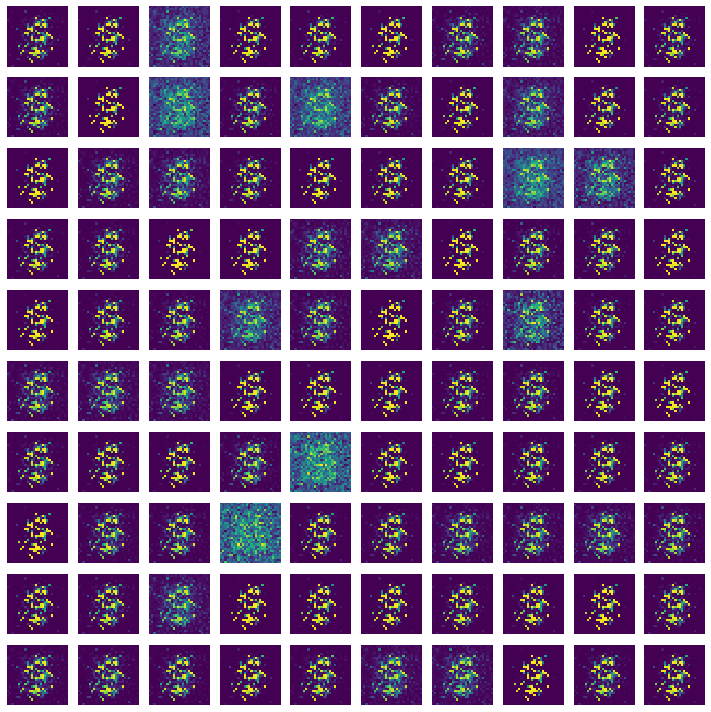

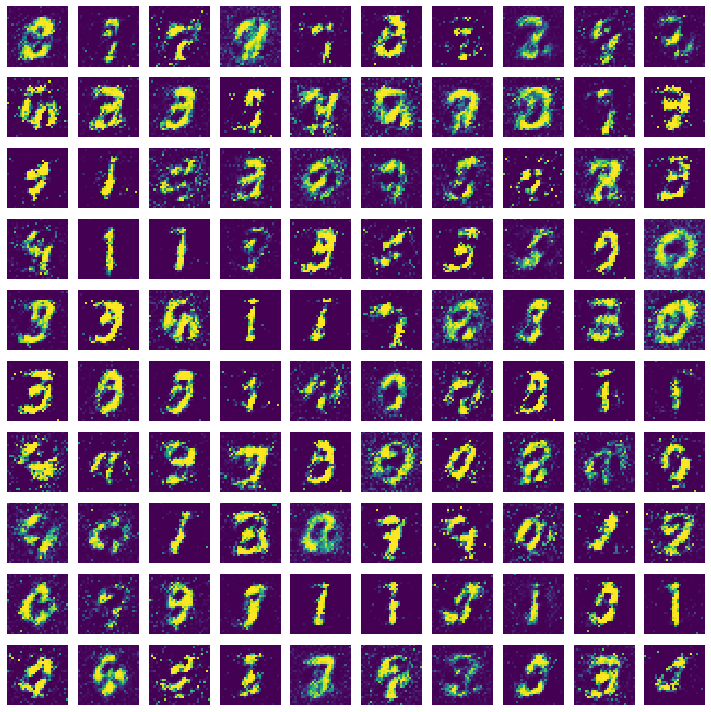

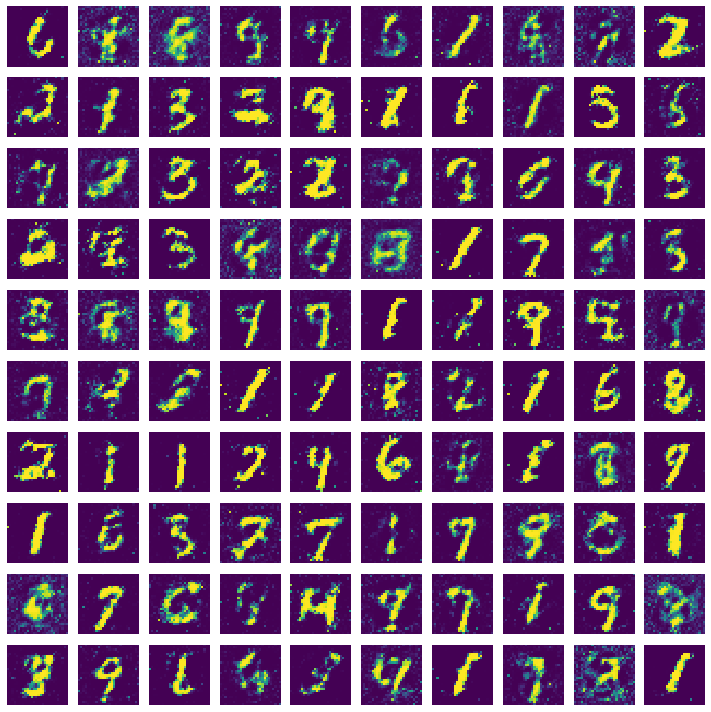

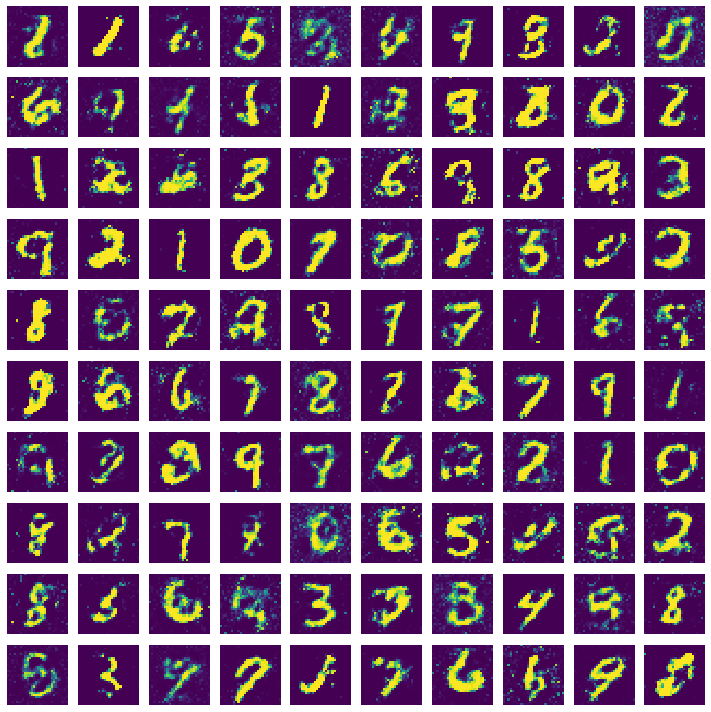

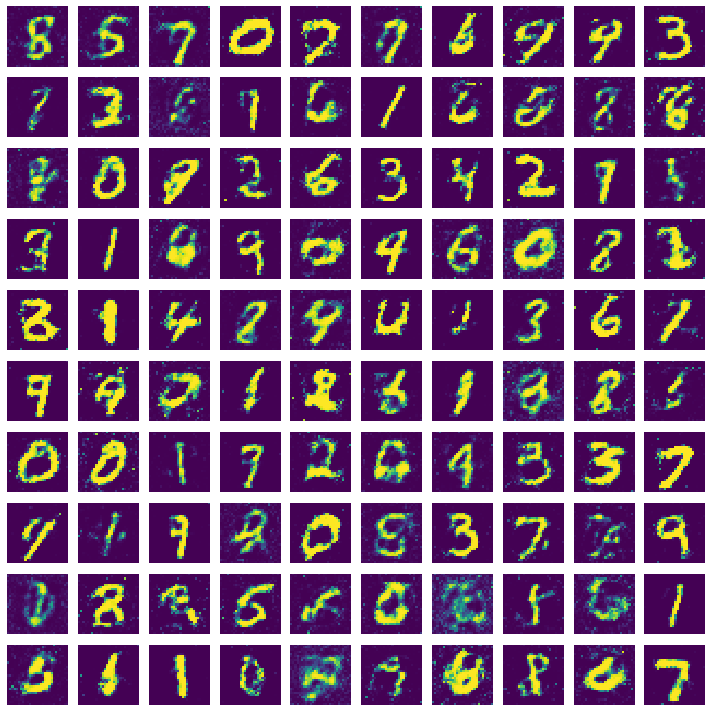

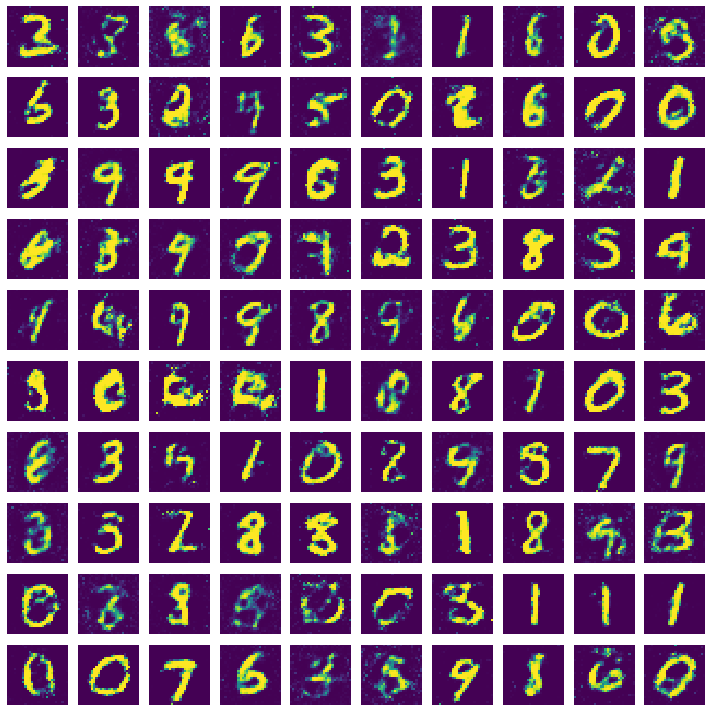

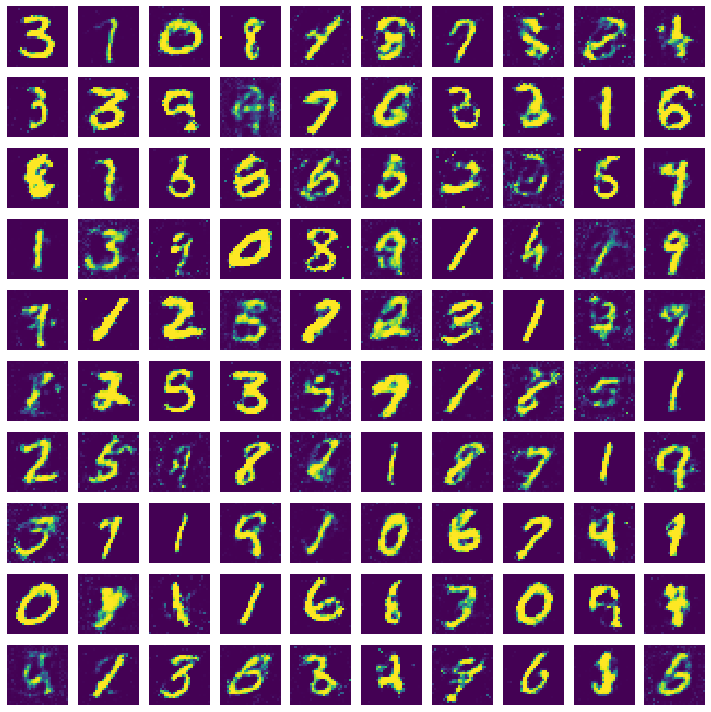

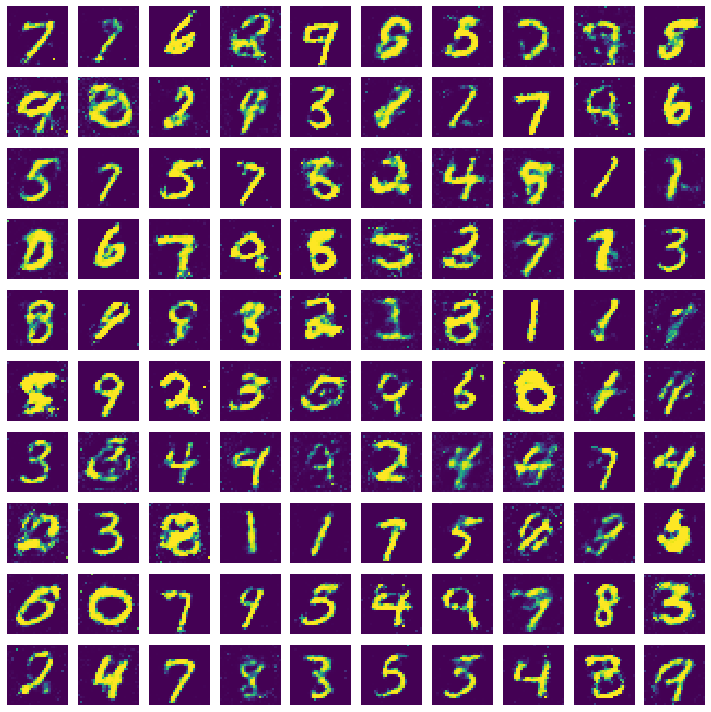

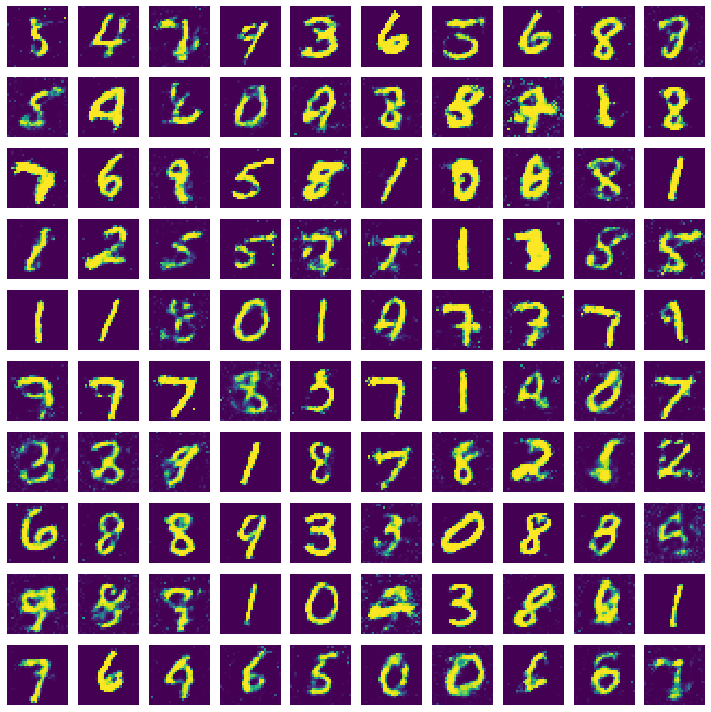

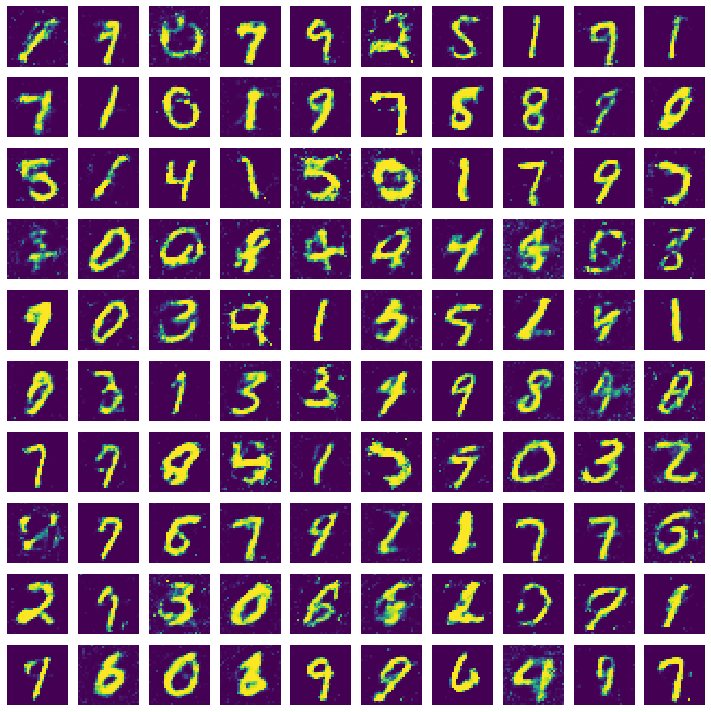

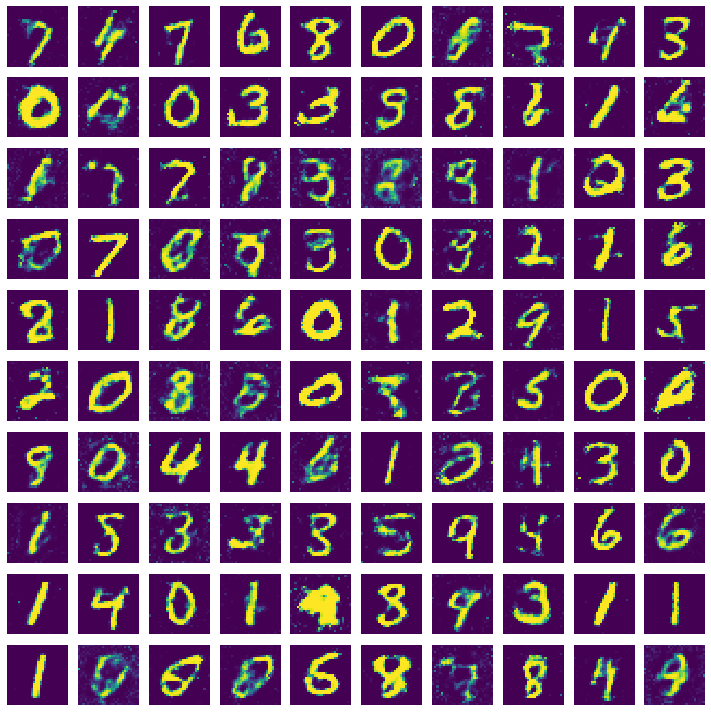

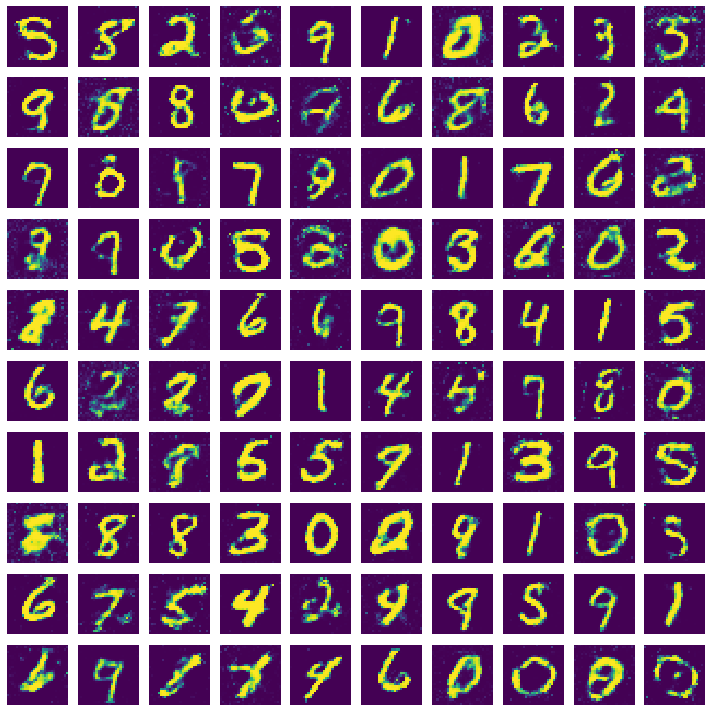

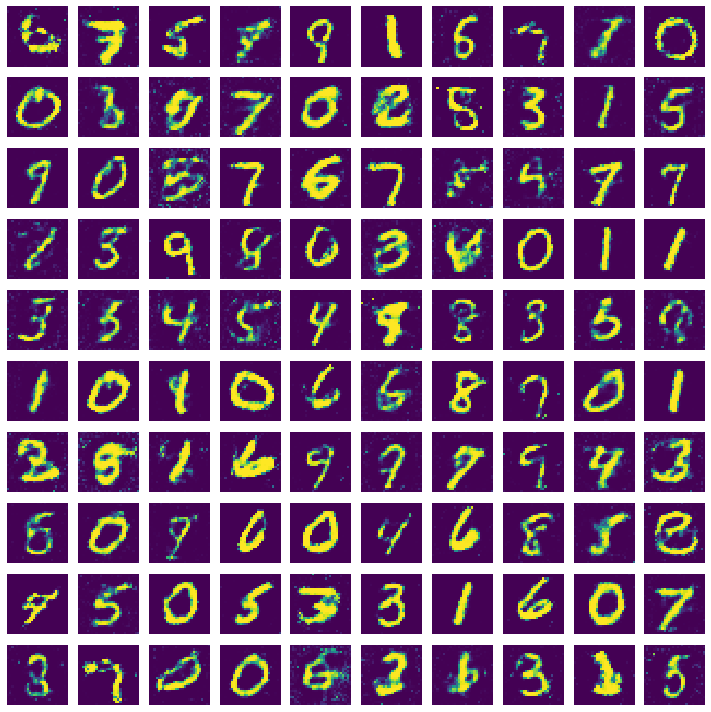

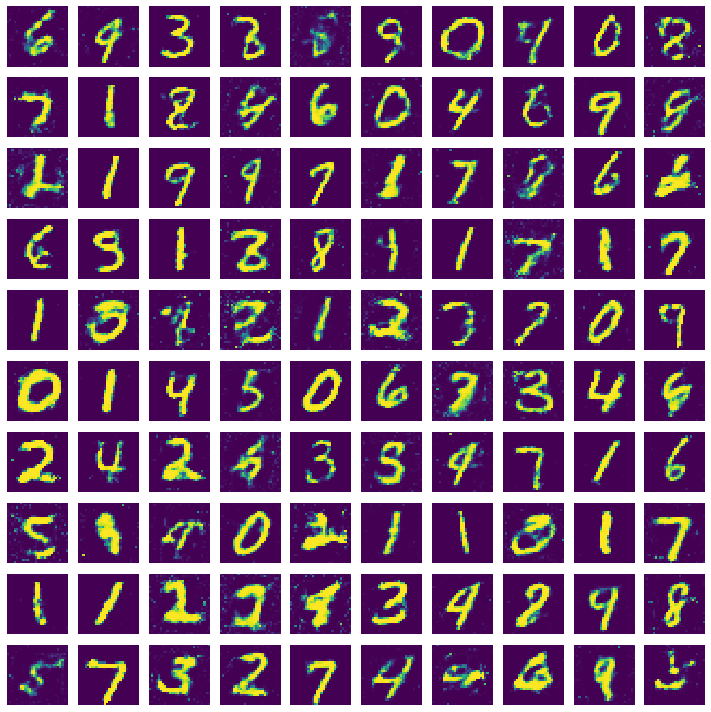

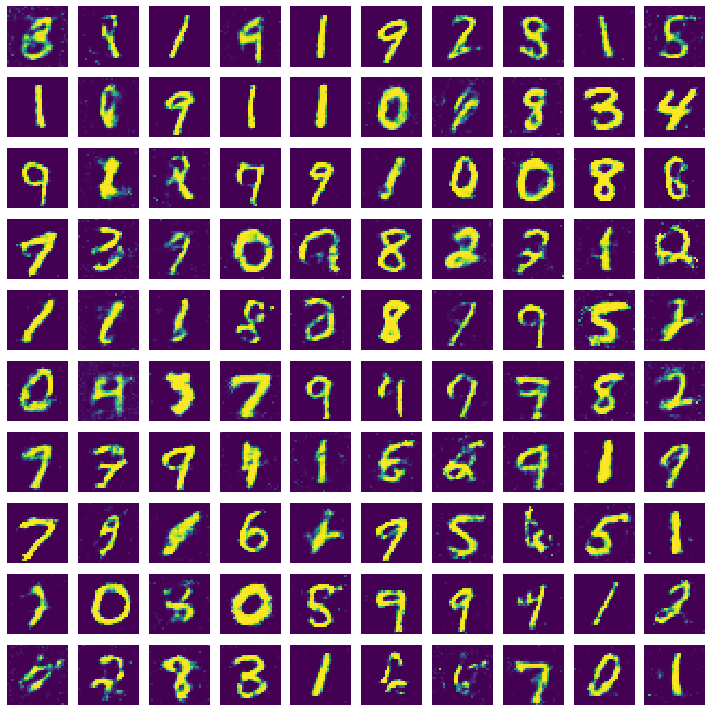

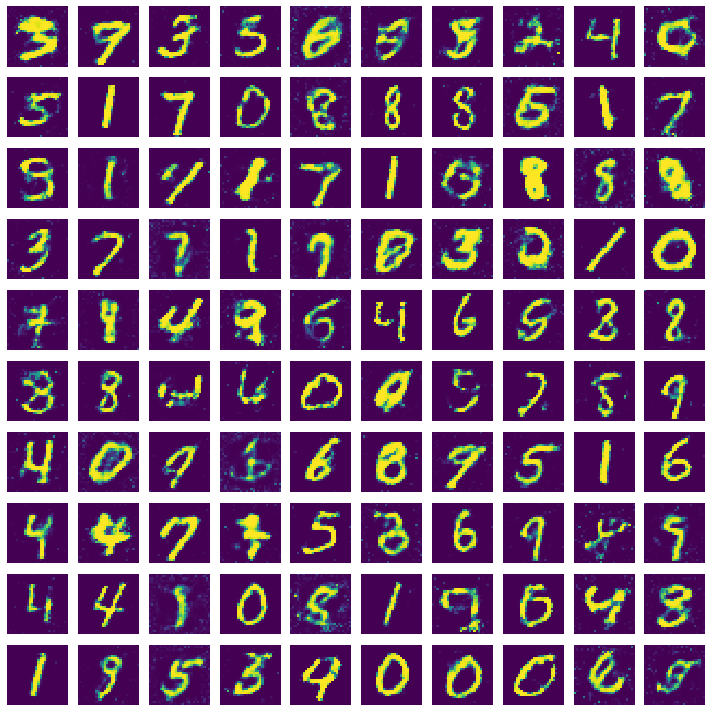

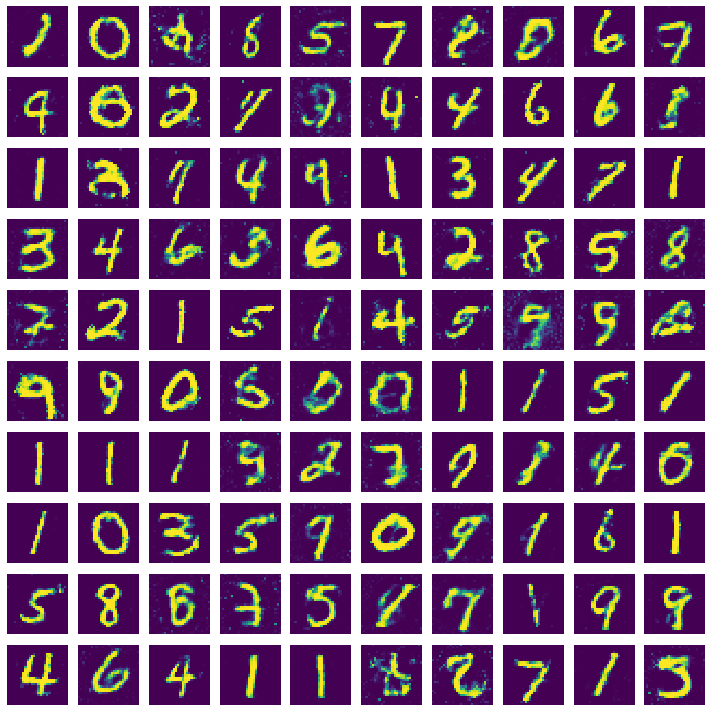

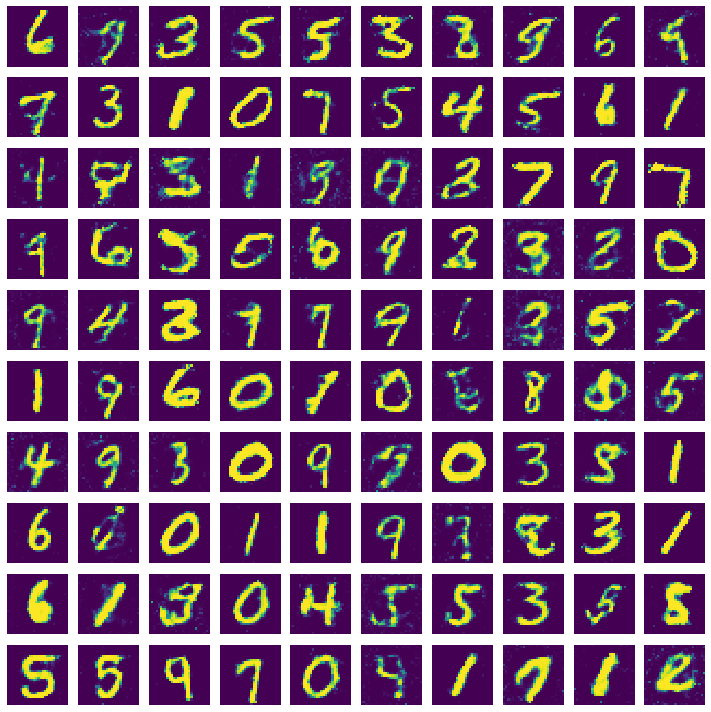

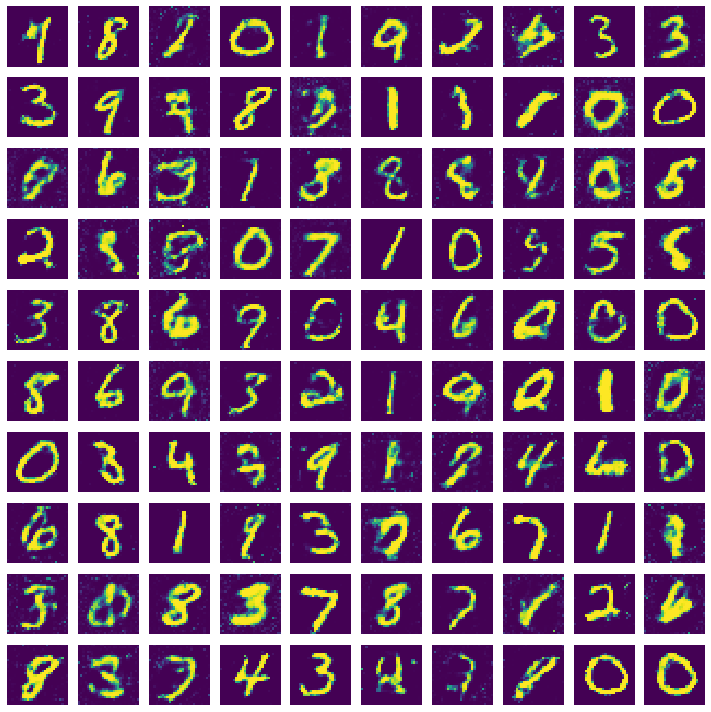

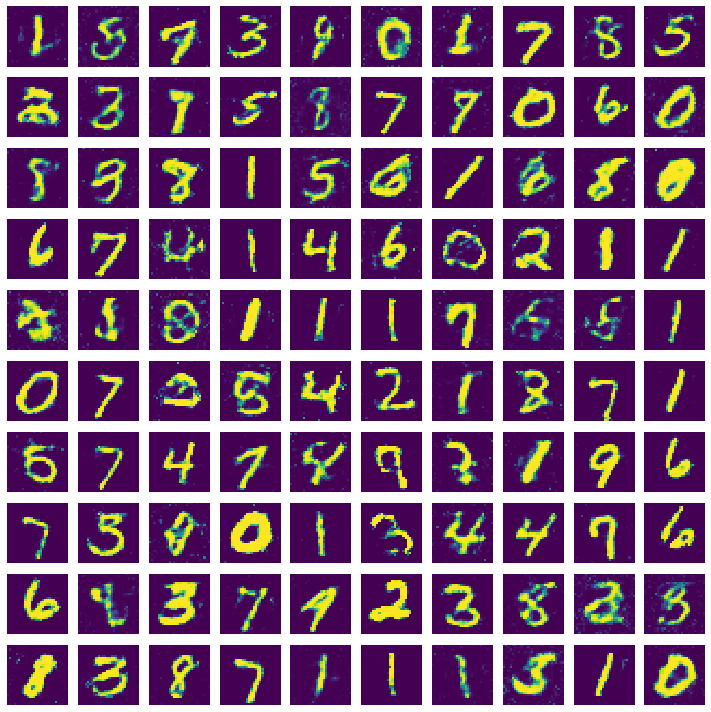

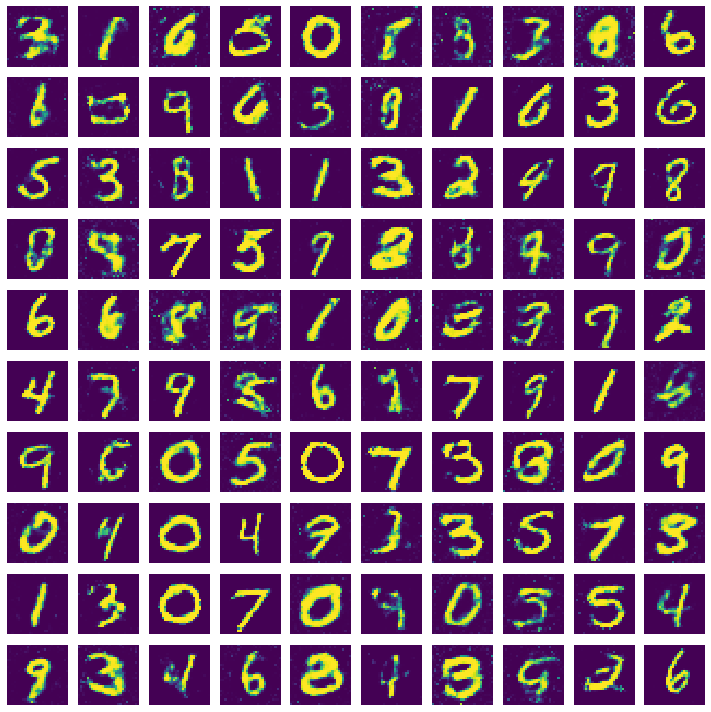

In [8]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
training(400,128)

In [10]:
(X_train, y_train, X_test, y_test) = load_data()

In [11]:
generator= create_generator()
discriminator= create_discriminator()
gan = create_gan(discriminator, generator)

In [13]:
generator

In [14]:
discriminator

In [15]:
gan